In [1]:
# Imports
import numpy as np
import pandas as pd
import xarray as xr
import hexMinisom
from minisom import MiniSom as MS
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import colormaps
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cf
from itertools import product
from sammon import sammon
import colorsys
import random
import pickle

In [2]:
dataset = xr.open_dataarray('data/Z500Anoms_ERA5.nc')

latSlice = slice(20, 80) #20N, 80N
lonSlice = slice(180, 330) #180W, 30W
dataarray = dataset.sel(lat=latSlice, lon=lonSlice)
dataarray = dataarray.stack(latlon=['lat', 'lon']).values

print(dataarray.shape)

(30660, 9211)


### Import SOM

In [ ]:
def save_som(som, fileName):
    with open(fileName, 'wb') as outfile:
        pickle.dump(som, outfile)

def load_som(fileName):
    with open(fileName, 'rb') as infile:
        som = pickle.load(infile)

    return som

som = load_som('pickles/SOM40.p')

n = som._num
xy = hexMinisom.xy_using_n(n)

mask = som._mask
node_indices_xy = np.ma.where(mask == False)
node_indices = list(zip(node_indices_xy[0], node_indices_xy[1]))
all_nodes = product(range(xy), range(xy))

inputLength = dataarray.shape[1]

winmap = som.win_map(dataarray, return_indices=True)

w = som._weights
minimum_weight = -np.max(np.abs(w))
maximum_weight = np.max(np.abs(w))


def generate_distinct_colors(n):
    colors = []
    
    # Generate `n` distinct colors in the HSV color space
    for i in range(n):
        # Generate a unique hue for each color, evenly spaced between 0 and 1
        hue = i / n
        # Use full saturation and value to get vibrant colors
        saturation = 1.0
        value = 1.0
        
        # Convert HSV to RGB (the result is a tuple of RGB values in [0, 1])
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        
        # Convert RGB to a format that ranges from 0 to 255 and create a hex string
        rgb = [int(x * 255) for x in rgb]
        hex_color = f"#{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}"
        
        colors.append(hex_color)

    random.shuffle(colors)

    return colors

color_list = generate_distinct_colors(len(node_indices))

#color_list = sns.color_palette('hls', len(node_indices))

### Pacific Trough Diversity

In [55]:
print(minimum_weight)
print(maximum_weight)
#print(min(dataarray.flatten()))

-1.8822302800430215
1.8822302800430215


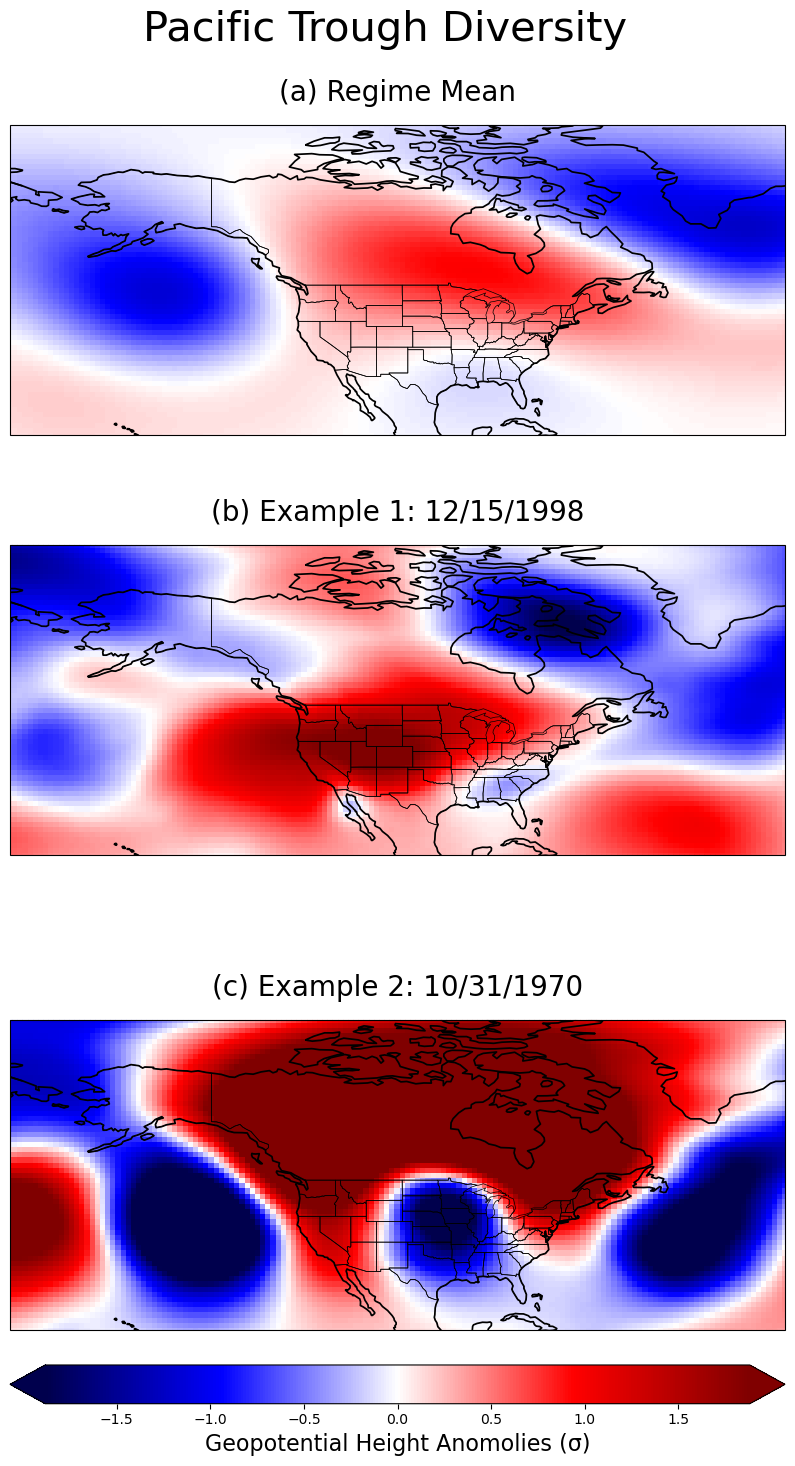

In [62]:
# Import the regime labels
WR_labels_df = pd.read_csv('data/df_labels_nocorrfilt_ERA5.csv')
WR_labels_df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
WR_labels_df['date'] = pd.to_datetime(WR_labels_df['date'], format='%Y-%m-%d')
WR_labels_dict = {0: 'Polar High', 1: 'Pacific Trough', 2: 'Pacific Ridge', 3: 'Alaskan Ridge', 4: 'Atlantic Ridge', 5: 'No WR'}
WR_labels = np.array(WR_labels_df['WR'])

# Set up our lats and lons
lats = dataset.sel(lat=latSlice, lon=lonSlice).lat
lons = dataset.sel(lat=latSlice, lon=lonSlice).lon - 360
lons, lats = np.meshgrid(lons, lats)

# get the closest and furthest distance days
wr = 1
closest = min(WR_labels_df[WR_labels_df['WR'] == wr]['distances'])
furthest = max(WR_labels_df[WR_labels_df['WR'] == wr]['distances'])
cidx = WR_labels_df[WR_labels_df['distances'] == closest].index[0]
fidx = WR_labels_df[WR_labels_df['distances'] == furthest].index[0]
cdata = dataarray[cidx].reshape((lons.shape[0], lats.shape[1]))
fdata = dataarray[fidx].reshape((lons.shape[0], lats.shape[1]))

# get the regime mean
wr_idxs = np.array(WR_labels == wr).nonzero()[0]
regime_mean = np.mean(dataarray[wr_idxs], axis=0).reshape((lons.shape[0], lats.shape[1]))

# Set up our figure
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 20))
axs = []

axs.append(plt.subplot2grid((3, 1), (0, 0), 1, 1, projection=proj))
axs.append(plt.subplot2grid((3, 1), (1, 0), 1, 1, projection=proj))
axs.append(plt.subplot2grid((3, 1), (2, 0), 1, 1, projection=proj))

# set up the background for each of the plots
for ax in axs:
    ax.set_extent([-180, -30, 20, 80], crs=proj)
    ax.coastlines(resolution='110m', color='k', linewidth=1.25, zorder=10)
    ax.margins(x=0, y=0)
    ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.5, zorder=10)
    ax.add_feature(cf.BORDERS, linewidth=0.5, zorder=10)

axs[0].pcolor(lons, lats, regime_mean, vmin=minimum_weight, vmax=maximum_weight, cmap='seismic', shading='nearest', transform=proj)
axs[0].set_title(f'(a) Regime Mean', fontsize=20, y=1.05)
axs[1].pcolor(lons, lats, cdata, vmin=minimum_weight, vmax=maximum_weight, cmap='seismic', shading='nearest', transform=proj)
axs[1].set_title(f'(b) Example 1: 12/15/1998', fontsize=20, y=1.05)
im = axs[2].pcolor(lons, lats, fdata, vmin=minimum_weight, vmax=maximum_weight, cmap='seismic', shading='nearest', transform=proj)
axs[2].set_title(f'(c) Example 2: 10/31/1970', fontsize=20, y=1.05)

# Colorbar
cb = fig.colorbar(im, location='bottom', orientation='horizontal', pad=.05, extend='both')
cb.set_label('Geopotential Height Anomolies (\u03C3)', loc='center', fontsize=16)

plt.suptitle('Pacific Trough Diversity', y=.84, fontsize=30)
plt.subplots_adjust(hspace=-.4)

plt.savefig('pdf_output/PT_Diversity.pdf')

### Area of Interest figure

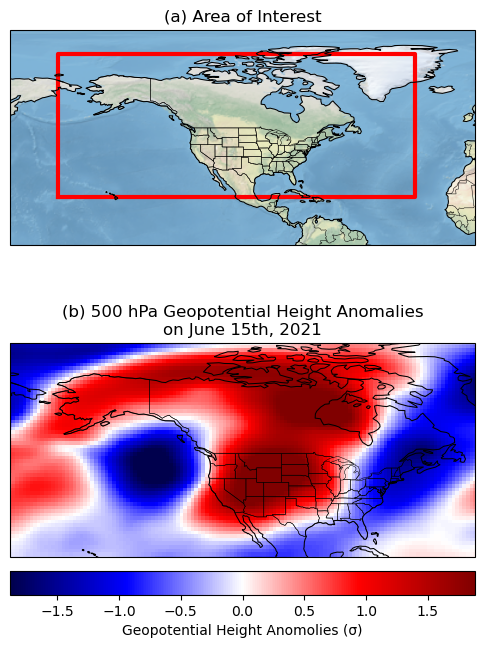

In [48]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

#fig = plt.figure()
proj = ccrs.PlateCarree(central_longitude=180)
#ax = plt.axes(projection=proj)
ax = axs[0]

ax.set_extent((-20, 175, 0, 90), crs=proj)
ax.stock_img()
ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)

ax.plot([0, 150, 150, 0, 0], [20, 20, 80, 80, 20], color='r', linewidth=3, transform=proj)
ax.set_title('(a) Area of Interest')
#plt.show()


day = '2021-06-15'
day = dataset.sel(time=day, lat=latSlice, lon=lonSlice).values
lats = dataset.sel(lat=latSlice, lon=lonSlice).lat
lons = dataset.sel(lat=latSlice, lon=lonSlice).lon

#fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
ax = axs[1]

ax.set_extent((0, 130, 20, 80), crs=proj)
im = ax.pcolormesh(lons, lats, day, vmin=minimum_weight, vmax=maximum_weight, cmap='seismic', transform=ccrs.PlateCarree())
ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
fig.colorbar(im, label='Geopotential Height Anomolies (\u03C3)', location='bottom', orientation='horizontal', pad=.05)
ax.set_title('(b) 500 hPa Geopotential Height Anomalies\non June 15th, 2021')

plt.savefig('pdf_output/Area_Of_Interest.pdf')

### Node Labels Figure

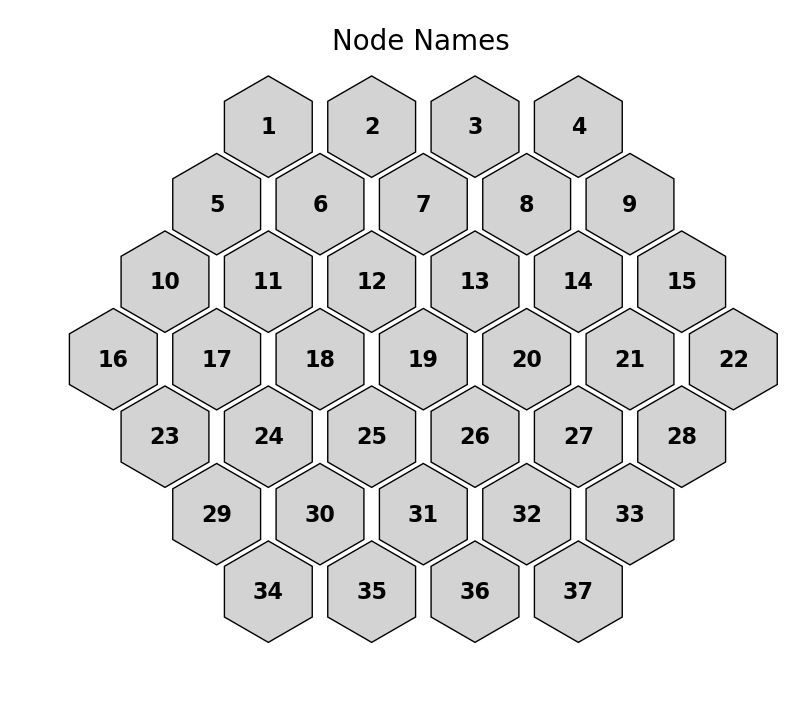

In [4]:
# set up the figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

# get data from the som
weights = som.get_weights()
xx, yy = som.get_euclidean_coordinates()
n = 1
   
# loops through the neurons
for i in range(weights.shape[0])[::-1]:
    for j in range(weights.shape[1]):

        
        # Only use non-masked nodes
        if som._mask[i, j] == 0:
                
            # determine the hexagon position and color
            wy = yy[(j, i)] * np.sqrt(3) / 2
            
            # Create hexagon and add it to axis
            hex = patches.RegularPolygon((xx[(j, i)], wy), numVertices=6, radius=.85 / np.sqrt(3), 
                                    facecolor='lightgrey', edgecolor='Black')
            ax.add_patch(hex)
            textColor = 'black'
            
            # add text to hexagon for its frequency
            plt.text(xx[(j, i)], wy - .075, f'{n}', {'horizontalalignment': 'center', 'color': textColor, 'fontsize': 16, 'fontweight': 'bold'})
            n += 1
        
# align figure to show all hexagons
plt.xlim(-1, weights.shape[0] - .5)
plt.ylim(-1, (weights.shape[1] - .5) * np.sqrt(3) / 2)

# remove the axis labels and lines
ax.axis('off')

# Title the plot
plt.title("Node Names", fontsize=20, y=.93, x=.53)

plt.savefig('pdf_output/SOM_Node_Labels.pdf')

### SOM Corner Bias Figure

In [3]:
row_neurons = 5
col_neurons = 5
inputLength = dataarray.shape[1]
sigma = 3.5
learning_rate = .005
decay_function = 'asymptotic_decay'
neighborhood_function = 'gaussian'
topology = 'hexagonal'
random_seed = 9

# TRAINING
hexsom = MS(row_neurons, col_neurons, inputLength, sigma=sigma, learning_rate=learning_rate, 
                neighborhood_function=neighborhood_function, decay_function=decay_function, random_seed=random_seed, topology=topology)
hexsom.pca_weights_init(dataarray)
hexsom.train(dataarray, 20000, random_order=True)

winmap = hexsom.win_map(dataarray, return_indices=True)

# Determine how consistant each weather regime is
regimePersistences = {}

for neuron in winmap:
    idxs = np.array(winmap[neuron])
    
    persistencesList = []
    diffs = np.diff(idxs)
    groups = np.split(diffs, np.where(diffs != 1)[0]+1)
    persistencesList = [len(l) for l in groups]
    persistencesList[-1] += 1
    numDays, count = np.unique(persistencesList, return_counts=True)
    #count = count / sum(count)
    
    regimePersistences[neuron] = (numDays, count)

# Caluculate the average persistence for each node
data = {k: round(sum(v[0] * v[1]) / sum(v[1]), 2) for k, v in regimePersistences.items()}

c:\Users\wichr\anaconda3\envs\wr_minisom\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


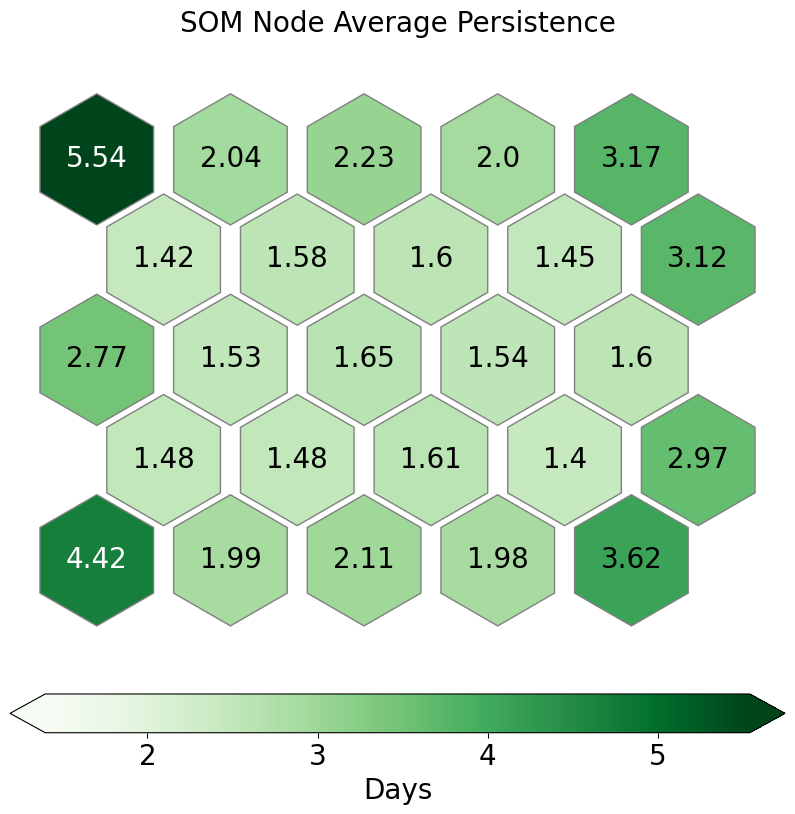

In [18]:
# set up the figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
cmap = mpl.colormaps['Greens']

# get data from the som
weights = hexsom.get_weights()
xx, yy = hexsom.get_euclidean_coordinates()

maxCount = max(v for v in data.values())
minCount = min(v for v in data.values())

# loops through the neurons
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        # If theres no data still plot the hexagon
        if (i, j) not in data:
            data[(i,j)] = 0
            
        # determine the hexagon position and color
        wx = xx[(i, j)]
        wy = yy[(i, j)] * np.sqrt(3) / 2
        colorWeight = data[(i, j)]/maxCount
        
        # Create hexagon and add it to axis
        hex = patches.RegularPolygon((wx, wy), numVertices=6, radius=.85 / np.sqrt(3), 
                                facecolor=cmap(colorWeight), edgecolor='grey')
        ax.add_patch(hex)
        
        # determine the color the text should be based on color of node
        if colorWeight >= .7:
            textColor = 'white'
        else:
            textColor = 'black'
        
        # add text to hexagon for its frequency
        plt.text(wx, wy-.05, f'{data[(i, j)]}', {'horizontalalignment': 'center', 'color': textColor, 'fontsize': 20})
        
# align figure to show all hexagons
plt.xlim(-1, weights.shape[0] - .5)
plt.ylim(-1, (weights.shape[1] - .5) * np.sqrt(3) / 2)

# remove the axis labels and lines
ax.axis('off')
#plt.gca().invert_yaxis()

# Create the color bar
norm = mpl.colors.Normalize(vmin=minCount, vmax=maxCount)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=1, extend='both', location='bottom', pad=0)
cb.set_label(label='Days', size=20)
cb.ax.tick_params(labelsize=20)

# Title the plot
plt.title("SOM Node Average Persistence", fontsize=20)
#plt.show()
plt.savefig('pdf_output/SOM_Corner_Bias.pdf', bbox_inches='tight')

In [ ]:
# Plotting functions
def hex_heatmap(som, data, cmap='Blues', title='', cbLabel=''):
    # set up the figure
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    cmap = mpl.colormaps[cmap]
    
    # get data from the som
    weights = som.get_weights()
    xx, yy = som.get_euclidean_coordinates()
    
    maxCount = max(v for v in data.values())
    #maxCount = 553  #frequency
    #maxCount = 4.39   #persistence
    minCount = min(v for v in data.values())
    #minCount = 65    #frequency
    #minCount = 1.23   #persistence
    
    # loops through the neurons
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            # Only use non-masked nodes
            if som._mask[i, j] == 0:
                # If theres no data still plot the hexagon
                if (i, j) not in data:
                    data[(i,j)] = 0
                    
                # determine the hexagon position and color
                wy = yy[(j, i)] * np.sqrt(3) / 2
                colorWeight = data[(i, j)]/maxCount
                
                # Create hexagon and add it to axis
                hex = patches.RegularPolygon((xx[(j, i)], wy), numVertices=6, radius=.85 / np.sqrt(3), 
                                        facecolor=cmap(colorWeight), edgecolor='grey')
                ax.add_patch(hex)
                
                # determine the color the text should be based on color of node
                if colorWeight >= .75:
                    textColor = 'white'
                else:
                    textColor = 'black'
                
                # add text to hexagon for its frequency
                plt.text(xx[(j, i)], wy - .05, f'{data[(i, j)]}', {'horizontalalignment': 'center', 'color': textColor, 'fontsize': 12})
            
    # align figure to show all hexagons
    plt.xlim(-1, weights.shape[0] - .5)
    plt.ylim(-1, (weights.shape[1] - .5) * np.sqrt(3) / 2)
    
    # remove the axis labels and lines
    ax.axis('off')
    
    # Create the color bar
    norm = mpl.colors.Normalize(vmin=minCount, vmax=maxCount)
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=.7)
    cb.set_label(cbLabel, size=12)
    cb.ax.tick_params(labelsize=12)
    
    
    # Title the plot
    plt.title(title, fontsize=20, y=.95, x=.515)
    
    return fig

def hex_frequency_plot(som, winmap=None):

    if winmap == None:
        winmap = som.win_map(dataarray)
    
    data = {k: len(v) for k, v in winmap.items()}
    
    fig = hex_heatmap(som, data, 'Blues', '(a) SOM Node Frequencies', 'Count')

    return fig

def hex_plot(som, projection=None):
    """Create a matplot lib figure with an axis for each neuron already positioned into the hexagonal shape"""
    
    # Extract the needed data from the som
    n = som._num
    xy = (2 * n) - 1
    mask = som._mask
    node_indices_xy = np.ma.where(mask == False)
    node_indices = list(zip(node_indices_xy[0], node_indices_xy[1]))

    # create figure
    totRows = xy * 3
    totCols = xy * 2
    fig = plt.figure(figsize=[totRows, totCols])
    axs = {}
    
    for x, y in list(product(range(xy), range(xy))):

        # make a subplot for the nodes not masked
        if (y, x) in node_indices: # for showing in the proper orientation x and y must be switched
            
            # odd rows will be offset to keep the hexagonal shape
            if y % 2 == 0:
                curRow = x * 3
            else:
                curRow = (x * 3) + 1
                
            curCol = (totCols - 2) - (y * 2)

            ax = plt.subplot2grid((totCols, totRows), (curCol, curRow), rowspan=2, colspan=2, projection=projection)
            ax.set_title((y, x))
            
            if projection is not None:
                ax.set_extent([-180, -30, 20, 80], crs=projection)
        
            axs[(y, x)] = ax
        
    return fig, axs

def hex_composite_map(som, winmap=None, somAvgs=None):
    
    
    fig, axs = hex_plot(som, projection=ccrs.PlateCarree())

    lats = dataset.sel(lat=latSlice, lon=lonSlice).lat
    lons = dataset.sel(lat=latSlice, lon=lonSlice).lon - 360
    lons, lats = np.meshgrid(lons, lats)
    
    if winmap == None:
        winmap = som.win_map(dataarray, return_indices=True)
    neurons = list(winmap.keys())

    for neuron in neurons:
        avgs = np.array(w[neuron[0], neuron[1], :]).reshape((lons.shape[0], lats.shape[1]))

        axs[neuron[0], neuron[1]].pcolor(lons, lats, avgs, vmin=minimum_weight, vmax=maximum_weight, cmap='seismic', shading='nearest', transform=ccrs.PlateCarree())
        
        axs[neuron[0], neuron[1]].set_title(f"Sample size: {len(winmap[(neuron[0], neuron[1])])}: {(neuron[0], neuron[1])})", fontsize=12)
        
        # background map features
        axs[neuron[0], neuron[1]].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
        axs[neuron[0], neuron[1]].margins(x=0, y=0)
        axs[neuron[0], neuron[1]].add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
        axs[neuron[0], neuron[1]].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)

    return fig

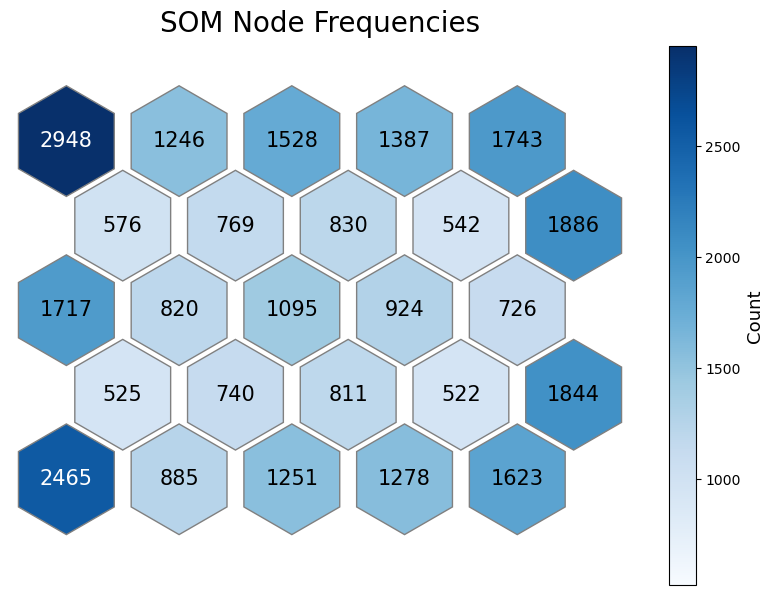

In [ ]:
data = {k: len(v) for k, v in winmap.items()}
    
fig = hex_heatmap(som, data, 'Blues', 'SOM Node Frequencies', 'Count')
plt.show()

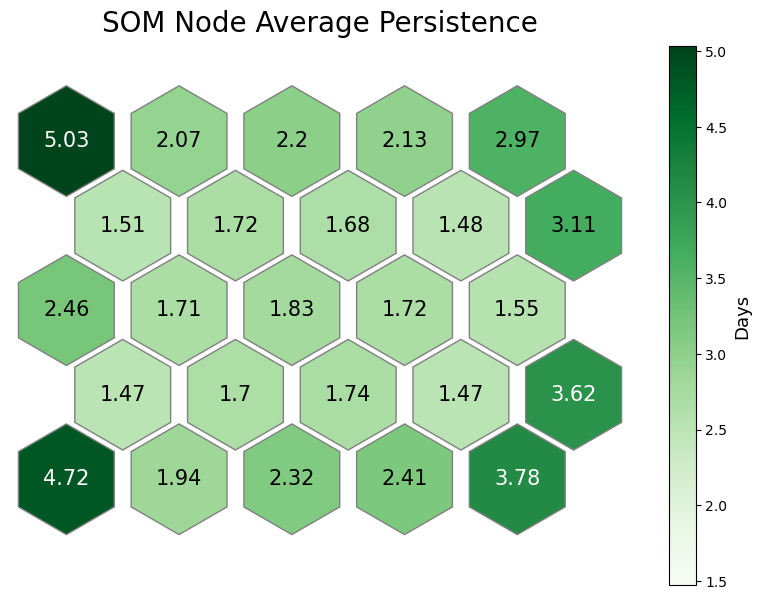

In [ ]:
# Determine how consistant each weather regime is
regimePersistences = {}

for neuron in winmap:
    idxs = np.array(winmap[neuron])
    
    persistencesList = []
    diffs = np.diff(idxs)
    groups = np.split(diffs, np.where(diffs != 1)[0]+1)
    persistencesList = [len(l) for l in groups]
    persistencesList[-1] += 1
    numDays, count = np.unique(persistencesList, return_counts=True)
    #count = count / sum(count)
    
    regimePersistences[neuron] = (numDays, count)

# Caluculate the average persistence for each node
averagePersistences = {k: round(sum(v[0] * v[1]) / sum(v[1]), 2) for k, v in regimePersistences.items()}

fig = hex_heatmap(som, averagePersistences, 'Greens', 'SOM Node Average Persistence', 'Days')

plt.show()

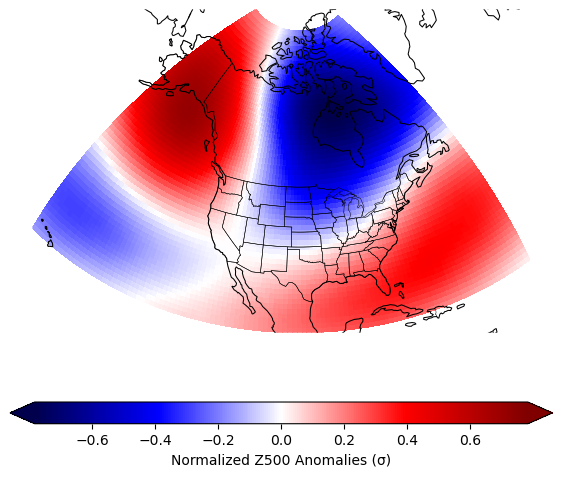

In [ ]:
lats = dataset.sel(lat=latSlice, lon=lonSlice).lat
lons = dataset.sel(lat=latSlice, lon=lonSlice).lon
lons, lats = np.meshgrid(lons, lats)

anoms = som._weights[0, 0, :].reshape((lons.shape[0], lats.shape[1]))
proj = ccrs.LambertAzimuthalEqualArea(central_latitude=50, central_longitude=-100)


fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=proj)

cmap = mpl.colormaps['seismic']
m = ax.pcolor(lons, lats, anoms, cmap=cmap, shading='nearest', norm=mpl.colors.CenteredNorm(), transform=ccrs.PlateCarree())

# colorbar
cbar = plt.colorbar(m, orientation='horizontal', shrink=.7, aspect=25, extend='both', label='Normalized Z500 Anomalies (\u03C3)')


# background map features
ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
ax.axis('off')

plt.savefig('AKR.png', dpi=500)

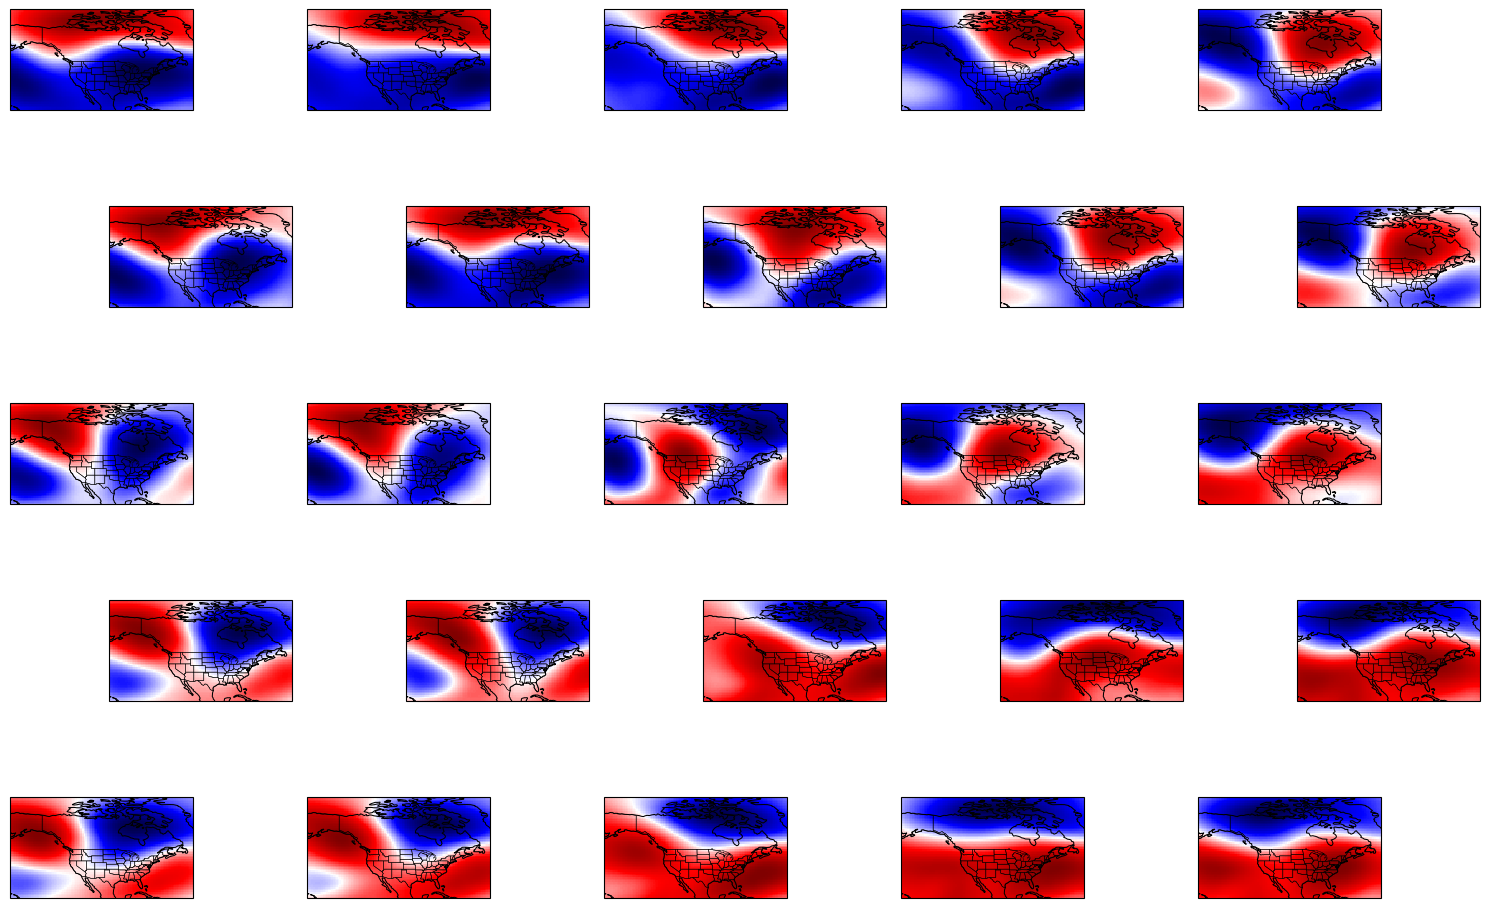

In [ ]:
fig = hex_composite_map(som, winmap=winmap)
fig.tight_layout()
plt.savefig('som_composite.pdf', bbox_inches='tight')